In [36]:
from fbprophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
INPUT_DIR = '../../input/m5-forecasting-accuracy'
sales=pd.read_csv(f'{INPUT_DIR}/sales_train_evaluation.csv')
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
calendar["date"] = pd.to_datetime(calendar["date"])

In [3]:
item_list = sales['item_id'].unique().tolist()
state_list = ['CA','TX','WI']
index_list = []
for state in state_list:
    for item in item_list:
        index_list.append(state+'_'+item)
df = pd.DataFrame(np.zeros([len(index_list), 1941]), columns=['d_'+str(i+1) for i in range(1941)], index = index_list)
for state in state_list:
    for item in item_list:
        df.iloc[df.index==state+'_'+item,0:] = sales[(sales['item_id']==item)&(sales['state_id']==state)].iloc[:,6:].sum().values

In [5]:
df.head()

d_1  d_2  d_3   d_4  d_5  d_6  d_7  d_8  d_9  d_10  ...  \
CA_HOBBIES_1_001  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
CA_HOBBIES_1_002  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
CA_HOBBIES_1_003  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
CA_HOBBIES_1_004  7.0  4.0  4.0  10.0  4.0  3.0  9.0  6.0  8.0   3.0  ...   
CA_HOBBIES_1_005  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   

                  d_1932  d_1933  d_1934  d_1935  d_1936  d_1937  d_1938  \
CA_HOBBIES_1_001     7.0    10.0     5.0     2.0     3.0     5.0     4.0   
CA_HOBBIES_1_002     0.0     2.0     2.0     1.0     1.0     0.0     0.0   
CA_HOBBIES_1_003     2.0     1.0     2.0     1.0     1.0     4.0     2.0   
CA_HOBBIES_1_004     3.0    14.0    16.0     5.0    10.0     5.0     8.0   
CA_HOBBIES_1_005     2.0     5.0     6.0     5.0     4.0     3.0     4.0   

                  d_1939  d_1940  d_1941  
CA_HOBBIES_1_001     6.0     3.0     4.0  
CA_HOBBIES_1_002     2.0     1.0     1.0  
CA_HOBBIES_1_003     5.0     1.0     3.0  
CA_HOBBIES_1_004     5.0     9.0    16.0  
CA_HOBBIES_1_005     7.0     7.0     4.0  

[5 rows x 1941 columns]

In [86]:
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2011-02-06','2012-02-05','2013-02-03','2014-02-02', '2015-02-01', '2016-02-07']),
  'lower_window': -3,
  'upper_window': 1,
})

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2011-01-30','2011-02-06',
                        '2012-01-07','2012-01-08','2012-01-14','2012-01-15','2012-01-22','2012-01-29','2012-02-05',
                        '2013-01-05','2013-01-06','2013-01-12','2013-01-13','2013-01-20','2013-01-27','2013-02-03',
                        '2014-01-04','2014-01-05','2014-01-11','2014-01-12','2014-01-19','2014-01-26','2014-02-02',
                        '2015-01-03','2015-01-04','2015-01-10','2015-01-11','2015-01-18','2015-01-25','2015-02-01',
                        '2016-01-09','2016-01-10','2016-01-16','2016-01-17', '2016-01-24',  '2016-01-31', '2016-02-07'
                       ]),
  'lower_window': -1,
  'upper_window': 1,
})

NBA_days= []
for i,t in zip(calendar[calendar['event_name_1']=='NBAFinalsStart'].index.tolist(),calendar[calendar['event_name_1']=='NBAFinalsEnd'].index.tolist()):
    NBA_days.extend(pd.DatetimeIndex(calendar['date'].iloc[i:(t+1)]).tolist())
NBA_days = pd.DatetimeIndex(NBA_days)

NBA = pd.DataFrame({
  'holiday': 'NBA',
  'ds': NBA_days,
  'lower_window': 0,
  'upper_window': 0,
})

Ramadan_days= []
Ramadan_end =['2011-08-29','2012-08-18','2013-08-07','2014-07-27','2015-07-16','2016-06-19']
for i,t in zip(calendar[calendar['event_name_1']=='Ramadan starts'].index.tolist(),calendar[calendar['date'].isin(Ramadan_end)].index.tolist()):
    Ramadan_days.extend(pd.DatetimeIndex(calendar['date'].iloc[i:(t+1)]).tolist())
Ramadan_days = pd.DatetimeIndex(Ramadan_days)

Ramadan = pd.DataFrame({
  'holiday': 'Ramadan',
  'ds': Ramadan_days,
  'lower_window': 0,
  'upper_window': 0,
})

Eid_ul_Fitr_day = pd.DataFrame({
  'holiday': 'Eid_ul_Fitr_day',
  'ds': pd.to_datetime(['2011-08-30','2012-08-19','2013-08-08','2014-07-28','2015-07-17','2016-06-20']),
  'lower_window': -1,
  'upper_window': 2,
})

black_friday = pd.DataFrame({
  'holiday': 'black_friday',
  'ds': pd.to_datetime(['2011-11-25','2012-11-23','2013-11-29','2014-11-28', '2015-11-27']),
  'lower_window': -1,
  'upper_window': 1,
})

CA_snap = pd.DataFrame({
  'holiday': 'ca_snap',
  'ds': pd.DatetimeIndex(calendar[calendar['snap_CA']==1]['date'].values),
  'lower_window': -1,
  'upper_window': 1,
})



holidays = superbowls
holi_col = ['holiday', 'ds', 'lower_window', 'upper_window']
for item in [playoffs,NBA,Ramadan,Eid_ul_Fitr_day,black_friday,CA_snap]:
    holidays = pd.concat([holidays.loc[:,holi_col],item.loc[:,holi_col]])

In [88]:
sample_df = pd.concat([calendar.loc[:1940,['date']], pd.DataFrame(df.T['CA_HOBBIES_1_001'].reset_index(drop=True))],axis=1)
sample_df = sample_df.rename({"date": "ds", "CA_HOBBIES_1_001": "y"}, axis=1)

In [89]:
def cut_outrange(in_df):
    out_df = in_df.copy()
    p0 =  out_df['y'].min()
    p95 = out_df['y'].quantile(0.95)
    out_df['y'] = out_df['y'].clip(p0,p95)
    return out_df

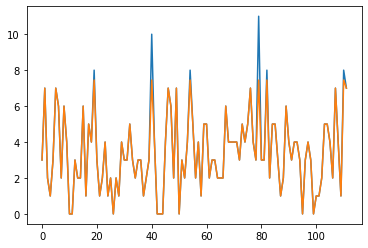

In [90]:
TRAIN_DAYS = 28*4
train = sample_df.iloc[-1*(TRAIN_DAYS+28):-28]
aa=cut_outrange(train)
plt.plot(train['y'].values)
plt.plot(aa['y'].values)
plt.show()

In [91]:
TRAIN_DAYS = 28*4
GROWTH = 1.01

model=Prophet(growth='logistic', holidays=holidays, seasonality_mode='multiplicative', weekly_seasonality=True,yearly_seasonality=True,daily_seasonality=True)
model.add_country_holidays(country_name='US')
train = cut_outrange(sample_df.iloc[-1*(TRAIN_DAYS+28):-28])
train['cap'] = train['y'].max()*GROWTH
model.fit(train)

future_df = model.make_future_dataframe(28)
future_df['cap'] = train['y'].max()*GROWTH
forecast_df = model.predict(future_df)

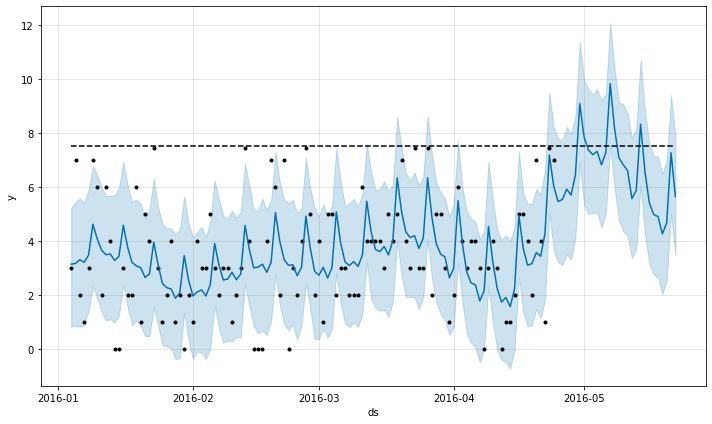

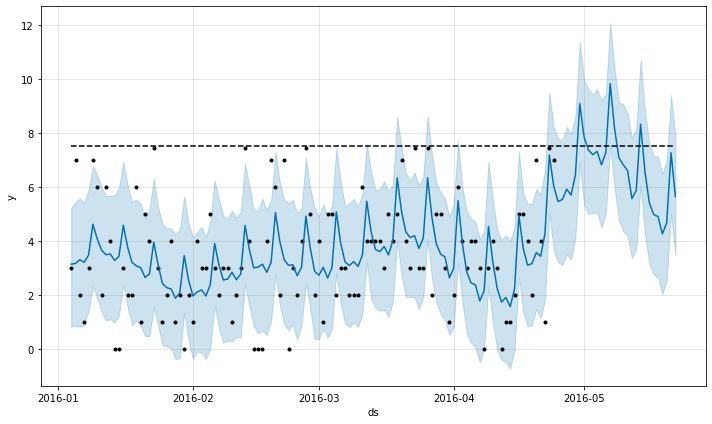

In [92]:
model.plot(forecast_df)

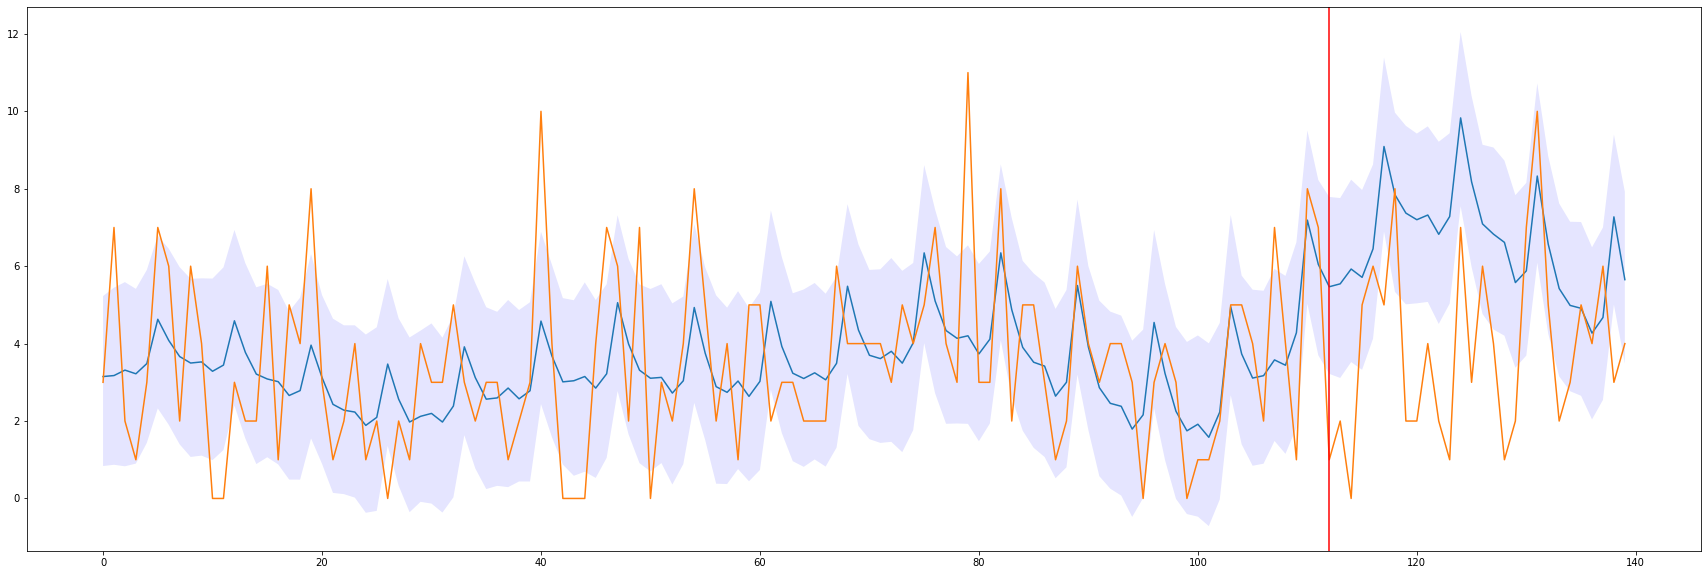

In [93]:
plt.figure(figsize=(30, 10))
plt.plot(forecast_df['yhat'][-1*(TRAIN_DAYS+28):].values)
plt.fill_between(np.arange(TRAIN_DAYS+28),forecast_df['yhat_upper'][-1*(TRAIN_DAYS+28):].values,forecast_df['yhat_lower'][-1*(TRAIN_DAYS+28):].values,facecolor='b',alpha=0.1)
plt.plot(sample_df['y'].iloc[-1*(TRAIN_DAYS+28):].values)
plt.axvline(x=TRAIN_DAYS, ymin=0, ymax=10,color='red')
plt.show()

In [94]:
def predict_prophet(df_name):
    sample_df = pd.concat([calendar.loc[:1940,['date']], pd.DataFrame(df.T[df_name].reset_index(drop=True))],axis=1)
    sample_df = sample_df.rename({"date": "ds", df_name: "y"}, axis=1)
    TRAIN_DAYS = 365*2
    GROWTH = 1.01

    model=Prophet(growth='logistic', holidays=holidays, seasonality_mode='multiplicative', weekly_seasonality=True,yearly_seasonality=True,daily_seasonality=False)
    model.add_country_holidays(country_name='US') 
    train = cut_outrange(sample_df.iloc[-1*(TRAIN_DAYS+28):-28])
    train['cap'] = train['y'].max()*GROWTH
    model.fit(train)

    future_df = model.make_future_dataframe(28)
    future_df['cap'] = train['y'].max()*GROWTH
    forecast_df = model.predict(future_df)
    
    model.plot(forecast_df)
    
    plt.figure(figsize=(30, 10))
    plt.plot(forecast_df['yhat'][-1*(TRAIN_DAYS+28):].values)
    plt.fill_between(np.arange(TRAIN_DAYS+28),forecast_df['yhat_upper'][-1*(TRAIN_DAYS+28):].values,forecast_df['yhat_lower'][-1*(TRAIN_DAYS+28):].values,facecolor='b',alpha=0.1)
    plt.plot(sample_df['y'].iloc[-1*(TRAIN_DAYS+28):].values)
    plt.axvline(x=TRAIN_DAYS, ymin=0, ymax=10,color='red')
    plt.show()
    
    plt.figure(figsize=(30, 10))
    plt.plot(forecast_df['yhat'][-56:].values)
    plt.fill_between(np.arange(56),forecast_df['yhat_upper'][-56:].values,forecast_df['yhat_lower'][-56:].values,facecolor='b',alpha=0.1)
    plt.plot(sample_df['y'].iloc[-56:].values)
    plt.axvline(x=28, ymin=0, ymax=10,color='red')
    plt.show()

In [95]:
df.head()

d_1  d_2  d_3   d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  \
CA_HOBBIES_1_001  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
CA_HOBBIES_1_002  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
CA_HOBBIES_1_003  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
CA_HOBBIES_1_004  7.0  4.0  4.0  10.0  4.0  3.0  9.0  6.0  8.0   3.0   4.0   
CA_HOBBIES_1_005  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   

                  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  \
CA_HOBBIES_1_001   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_002   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_003   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_004   2.0  12.0   5.0   5.0  12.0   2.0   6.0   3.0   3.0   3.0   
CA_HOBBIES_1_005   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                  d_22  d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  \
CA_HOBBIES_1_001   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_002   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_003   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_004  16.0  11.0   0.0   1.0   0.0   2.0   2.0   8.0  18.0   8.0   
CA_HOBBIES_1_005   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                  d_32  d_33  d_34  d_35  d_36  d_37  d_38  d_39  d_40  d_41  \
CA_HOBBIES_1_001   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_002   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_003   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_004   8.0   0.0   0.0   6.0  11.0   4.0   0.0   0.0  13.0   5.0   
CA_HOBBIES_1_005   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                  d_42  d_43  d_44  d_45  d_46  d_47  d_48  d_49  d_50  d_51  \
CA_HOBBIES_1_001   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_002   0.0   1.0   0.0   2.0   0.0   0.0   1.0   0.0   0.0   0.0   
CA_HOBBIES_1_003   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_004   7.0   8.0  11.0   2.0   8.0   1.0   2.0   8.0   5.0  10.0   
CA_HOBBIES_1_005   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  d_61  \
CA_HOBBIES_1_001   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_002   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_003   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_004   8.0   6.0   4.0   3.0   3.0   1.0   6.0   3.0   3.0   3.0   
CA_HOBBIES_1_005   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  \
CA_HOBBIES_1_001   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_002   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_003   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_004   8.0   3.0  10.0  14.0   2.0   2.0   4.0   4.0   6.0   6.0   
CA_HOBBIES_1_005   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                  d_72  d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  \
CA_HOBBIES_1_001   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_002   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_003   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_004   5.0   8.0   7.0   2.0   7.0   4.0  14.0  14.0   2.0  10.0   
CA_HOBBIES_1_005   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                  d_82  d_83  d_84  d_85  d_86  d_87  d_88  d_89  d_90  d_91  \
CA_HOBBIES_1_001   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CA_HOBBIES_1_002   0.0

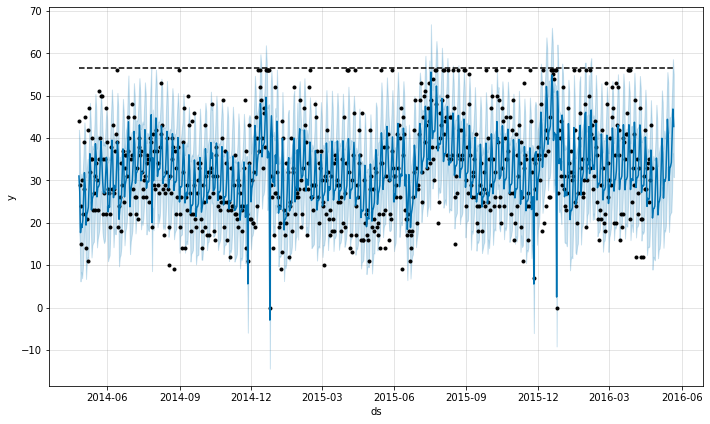

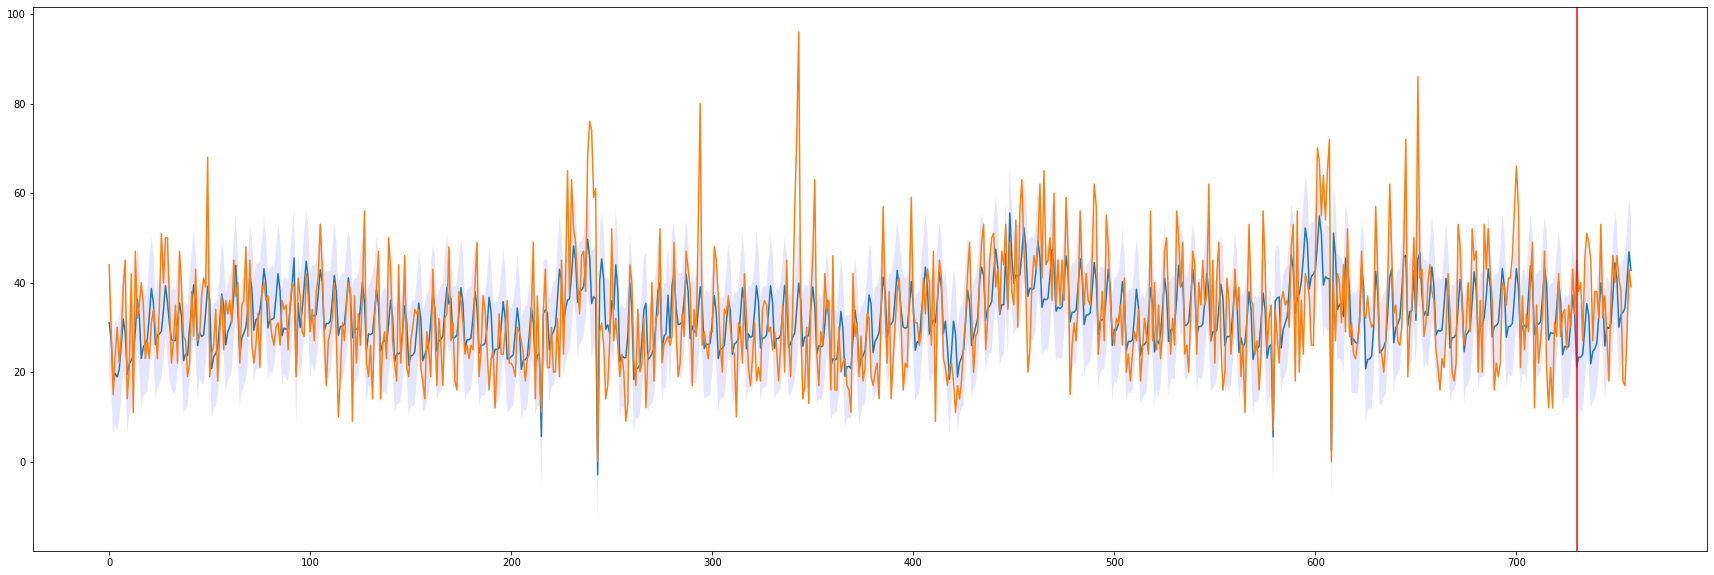

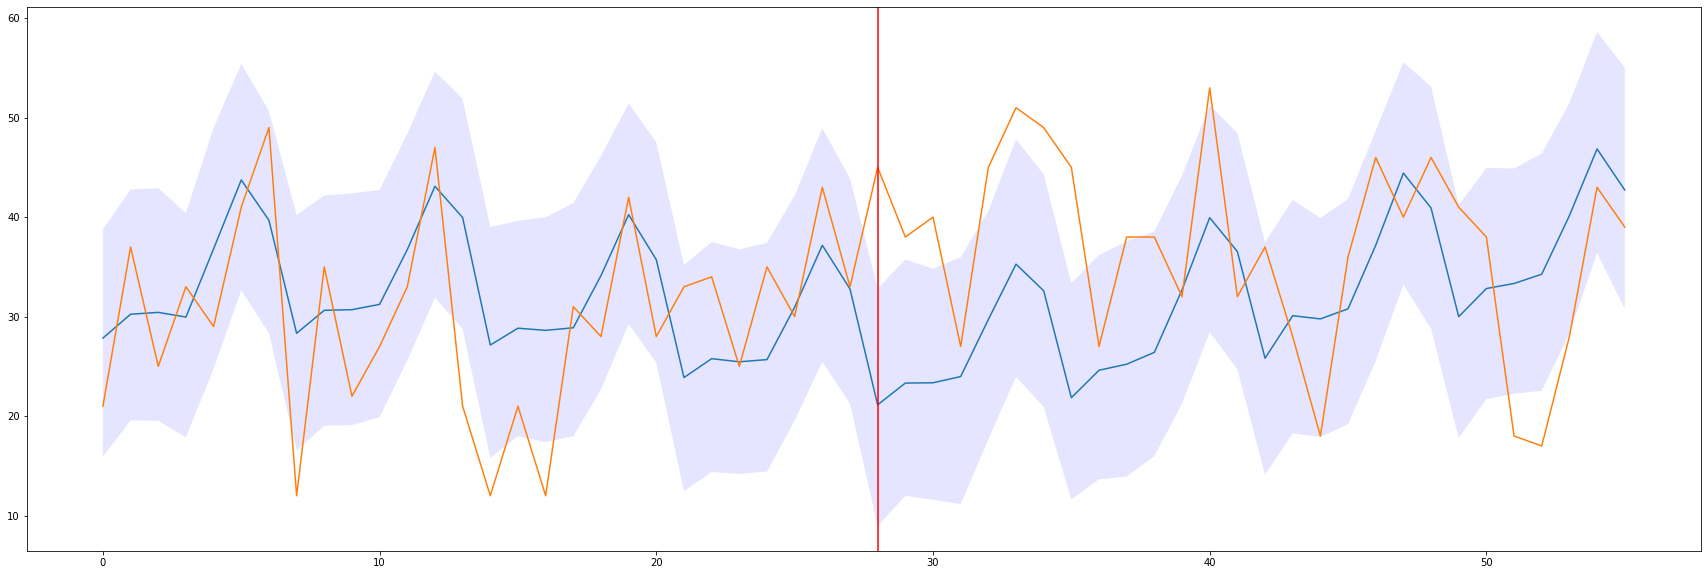

In [96]:
predict_prophet('CA_FOODS_1_099')

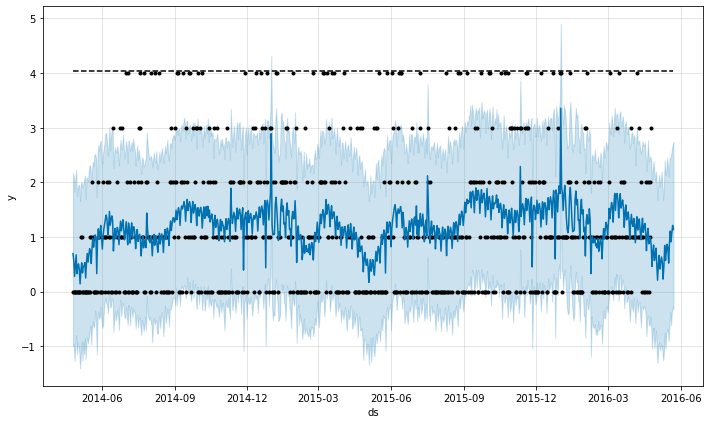

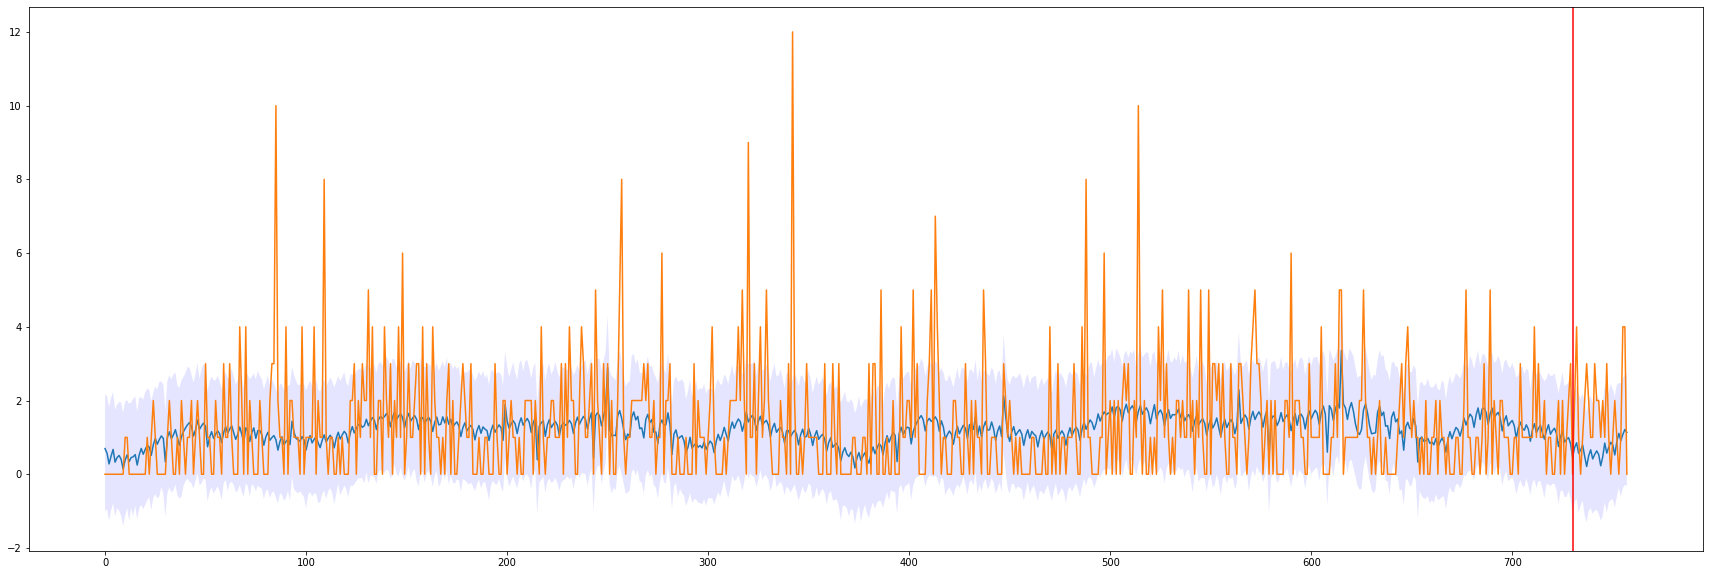

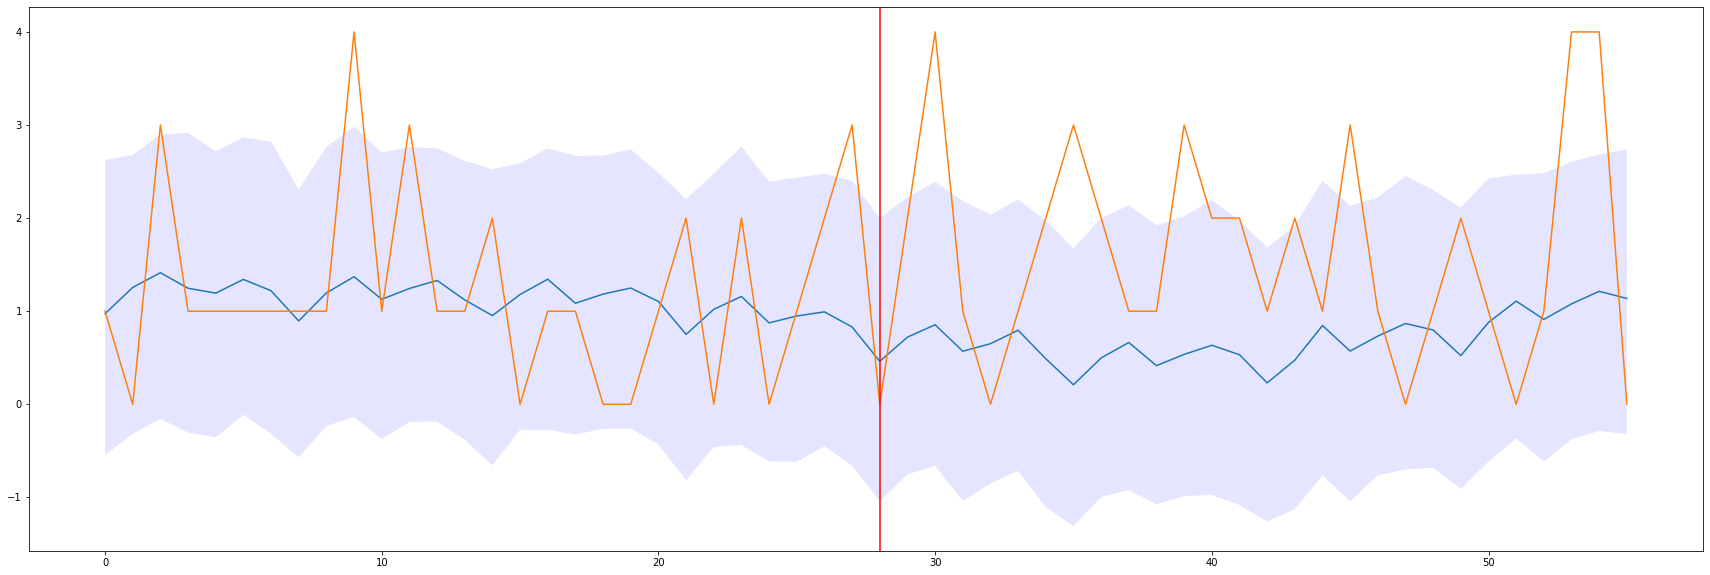

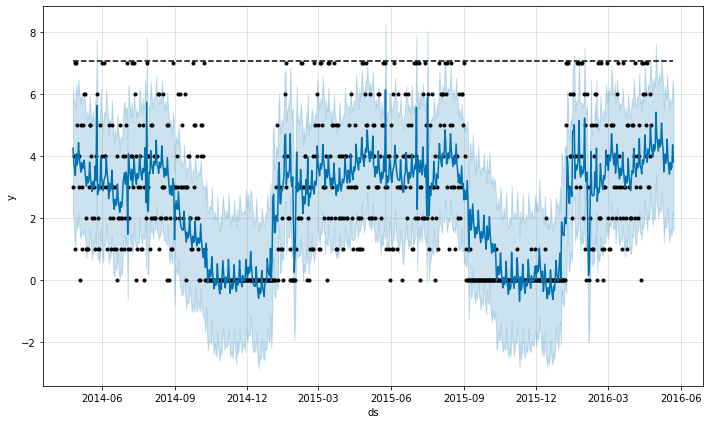

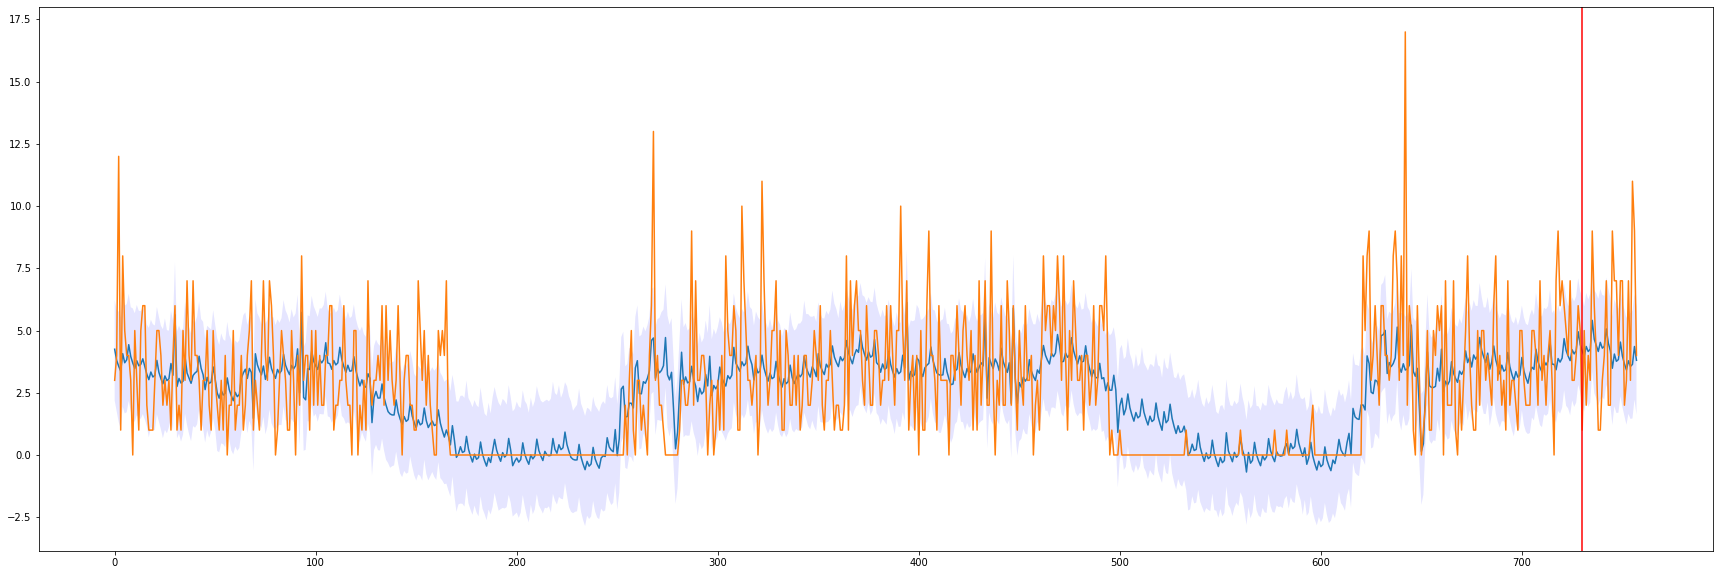

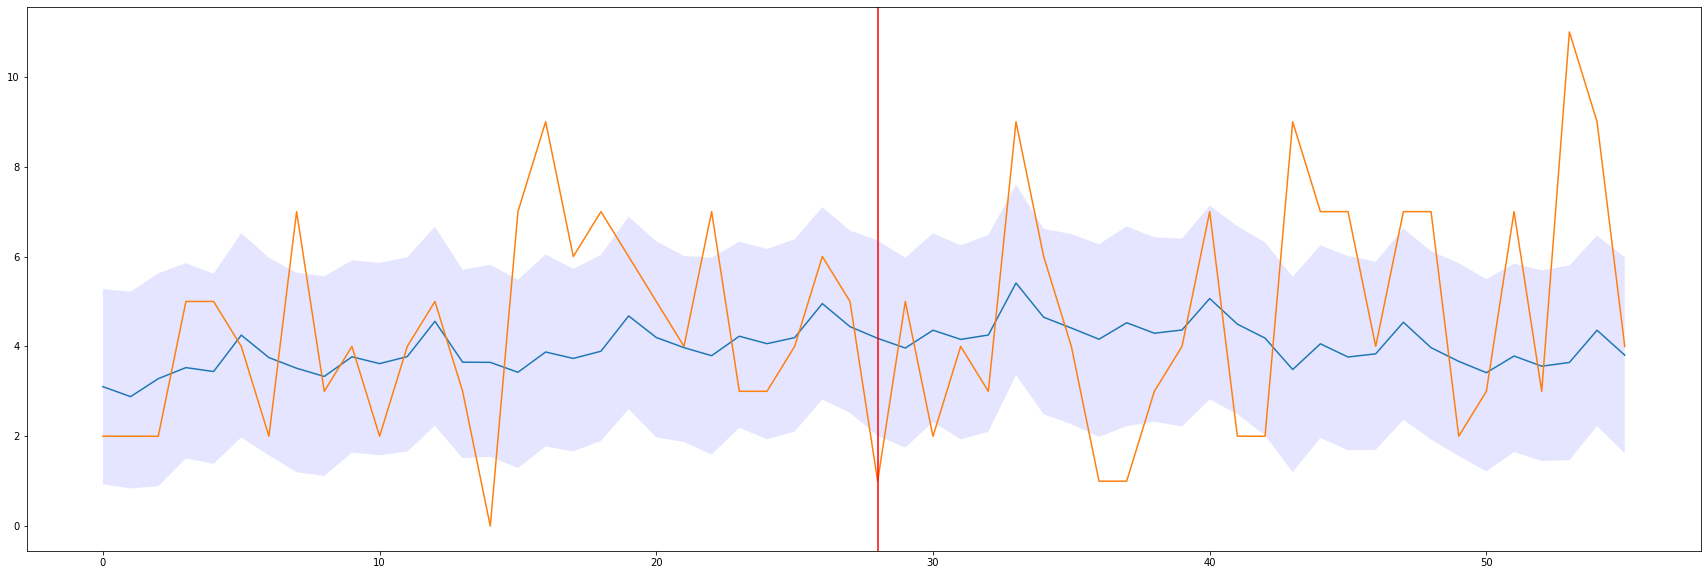

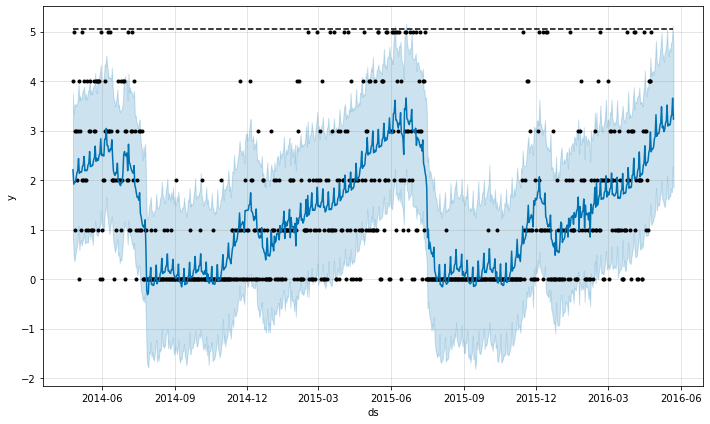

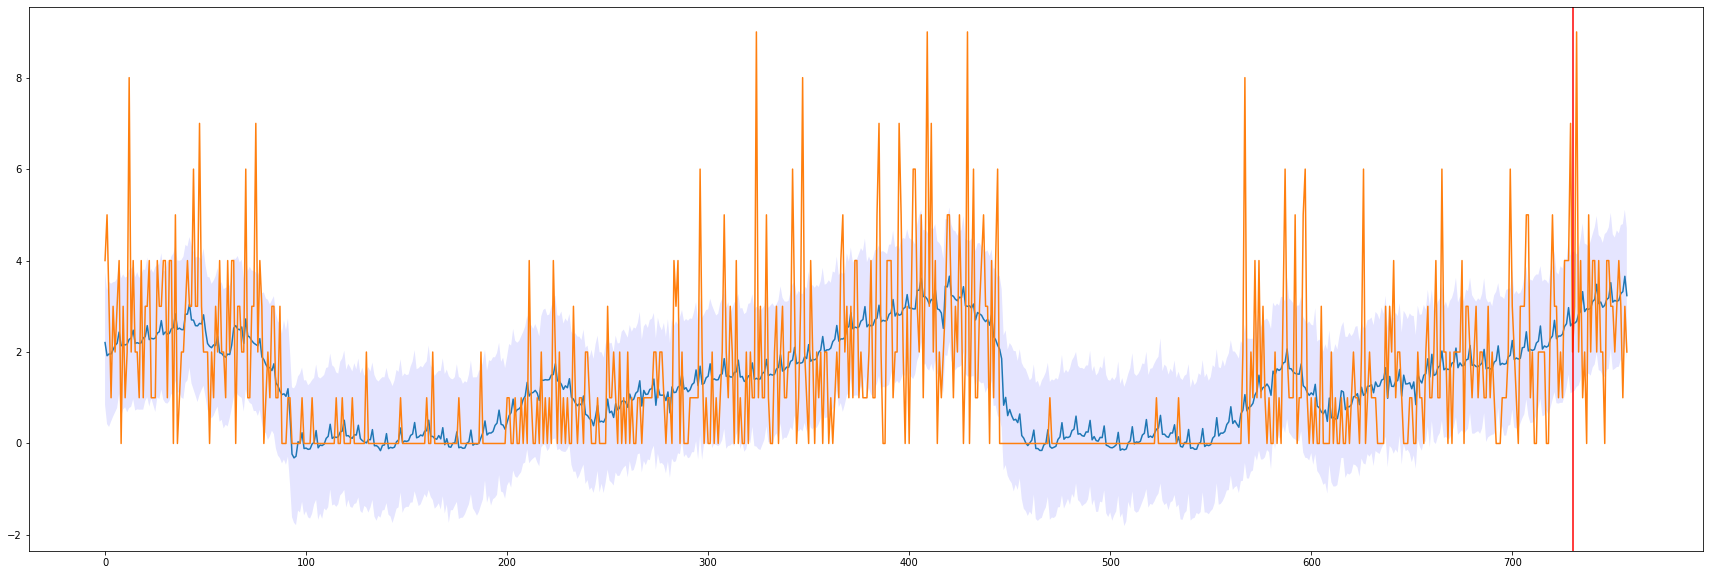

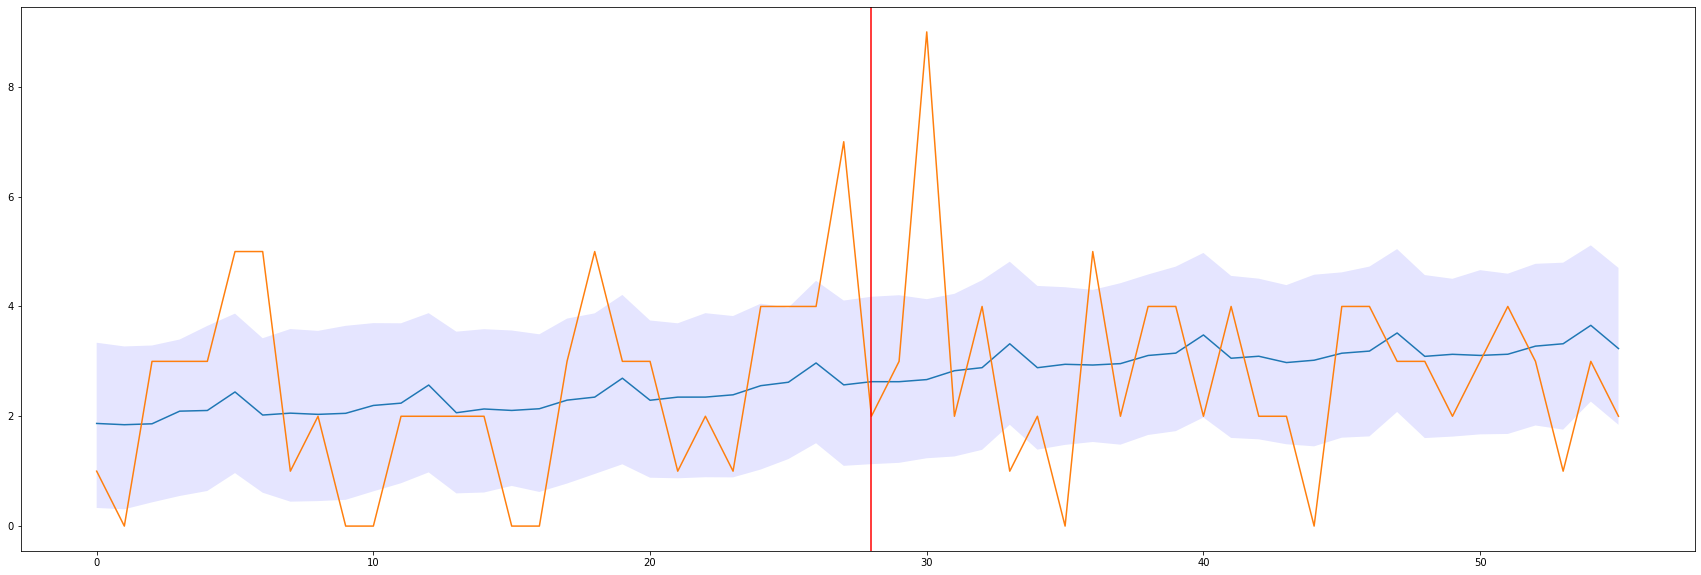

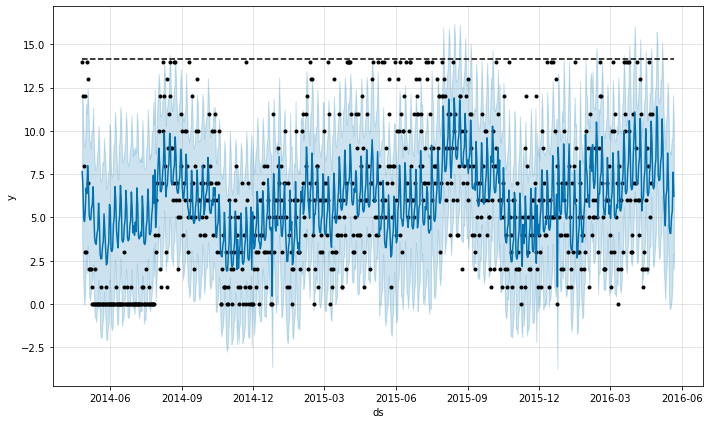

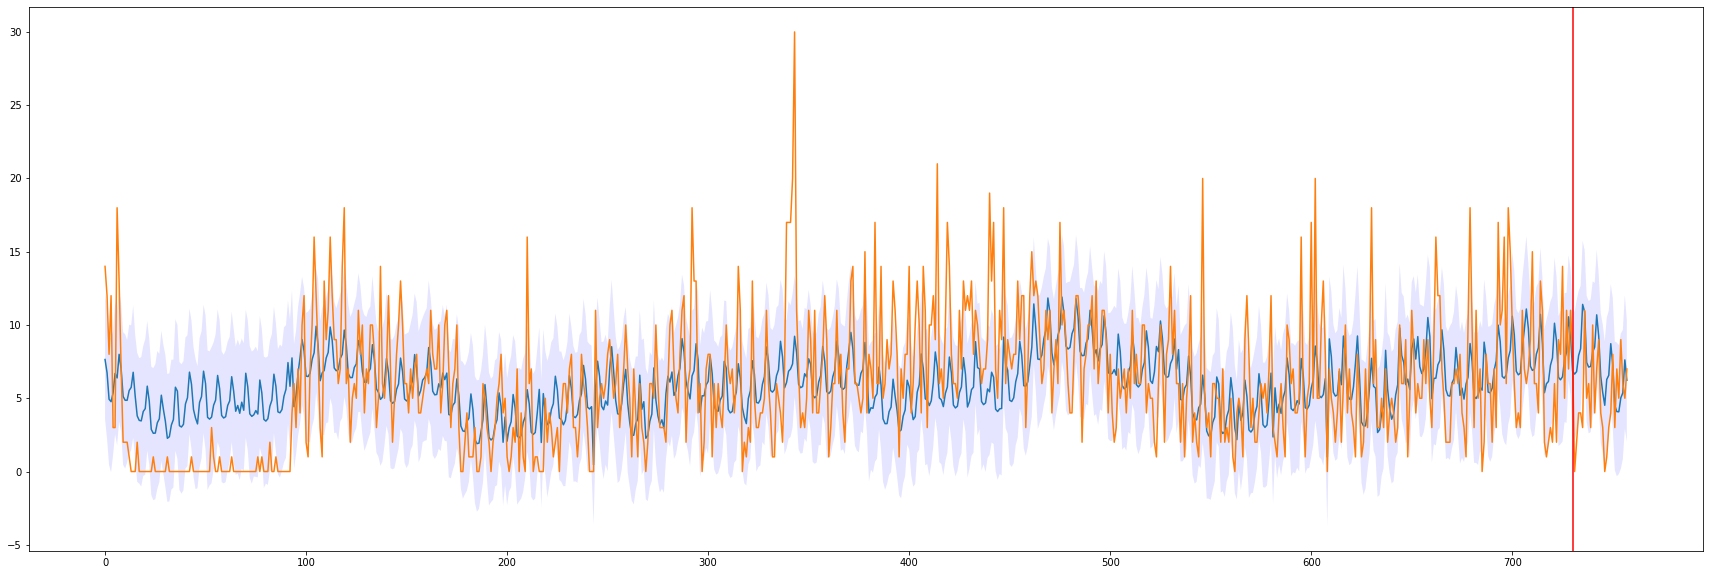

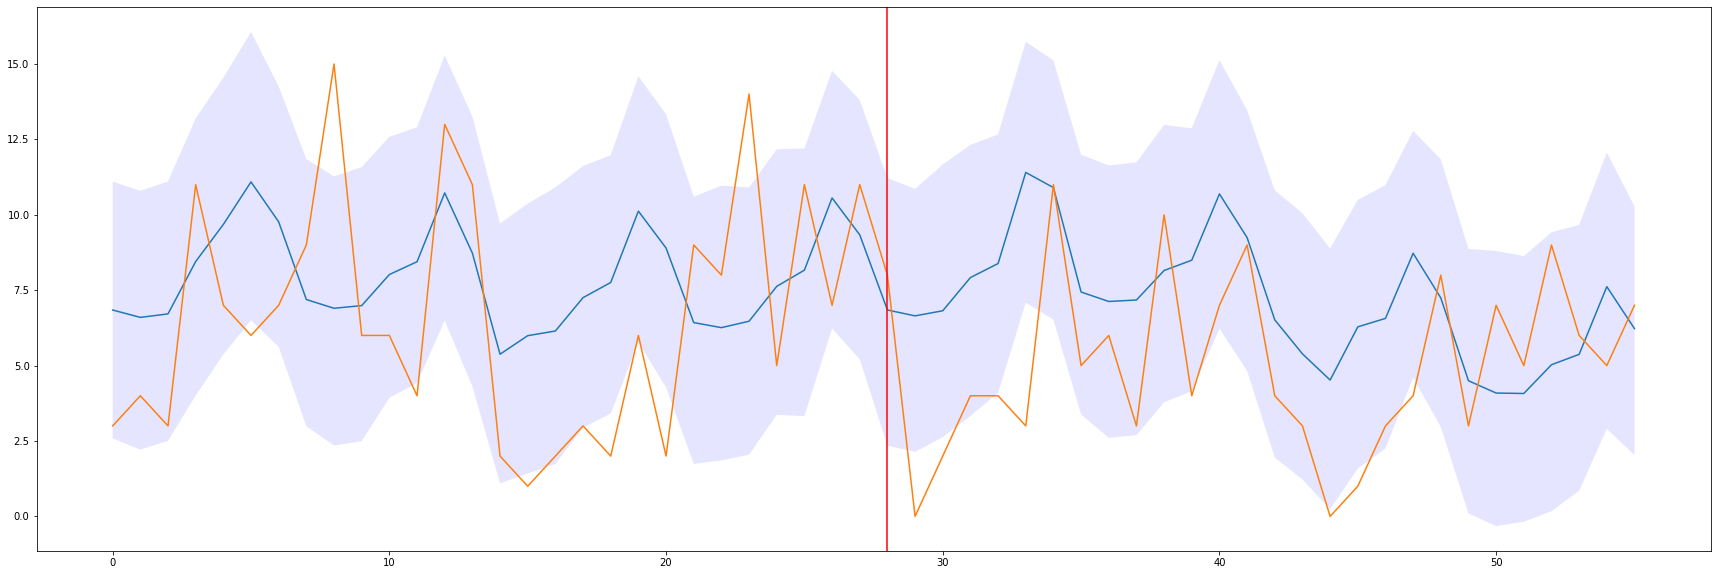

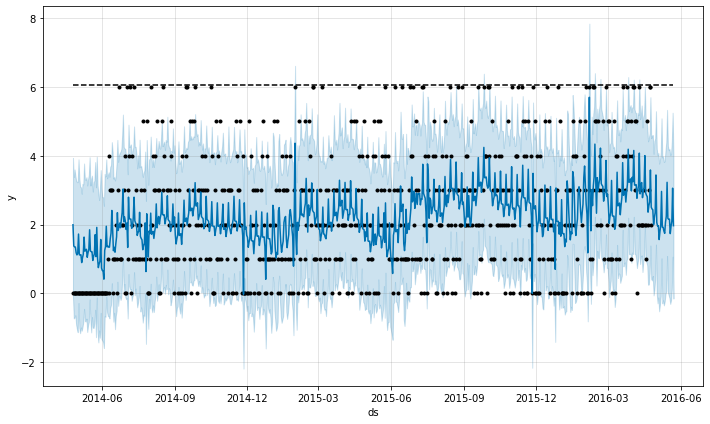

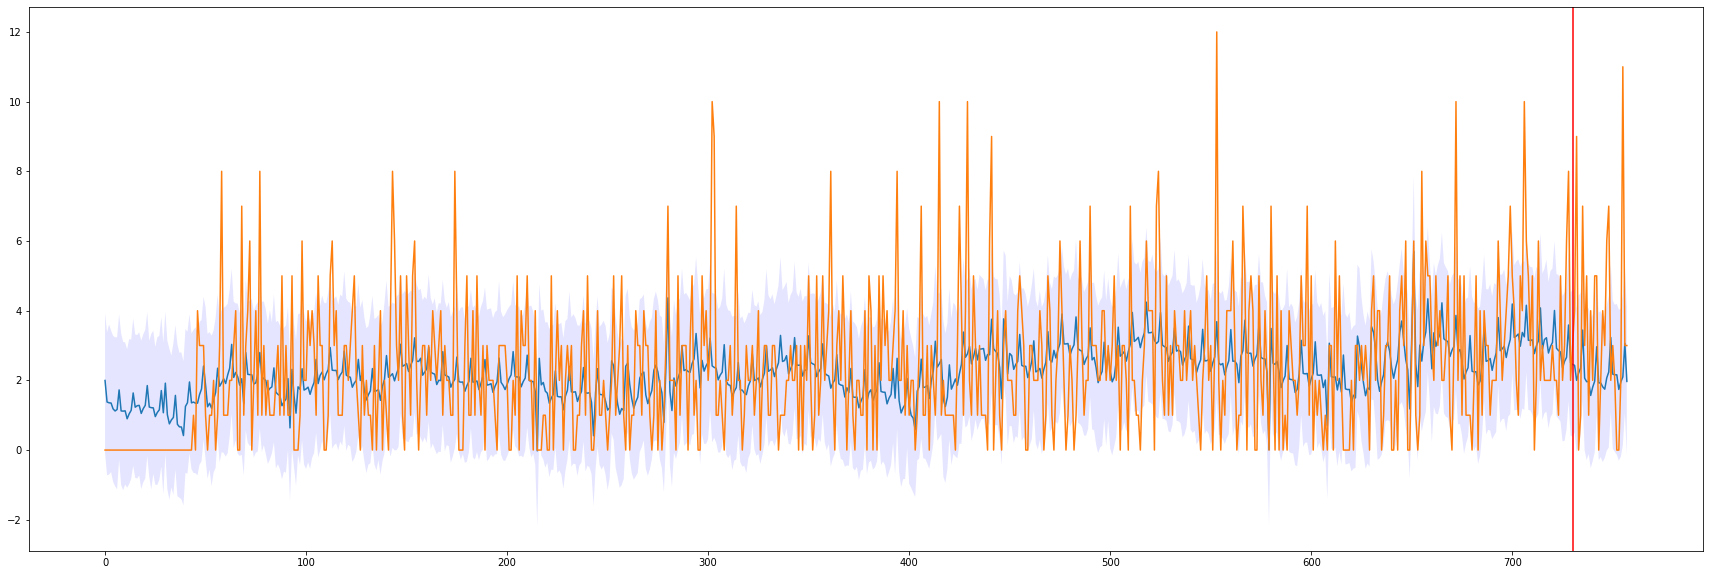

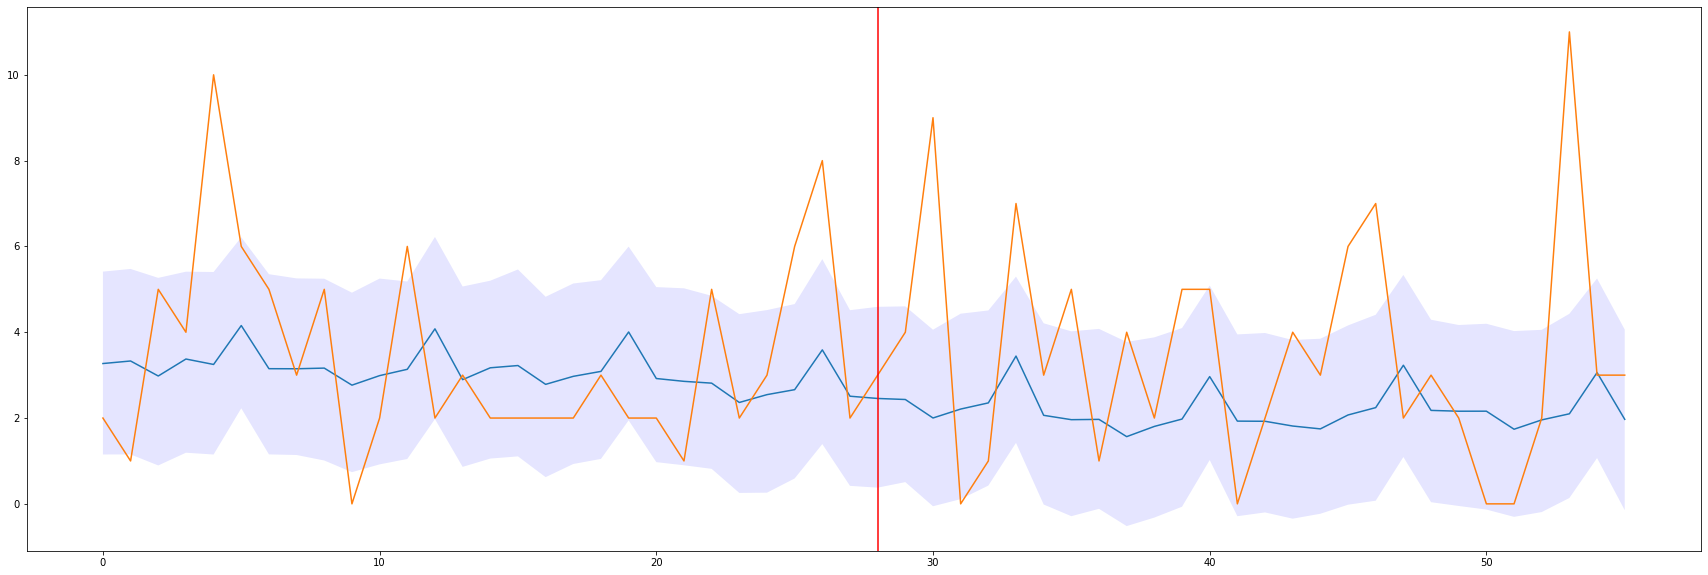

In [97]:
for i in range(5):
    predict_prophet(f'CA_FOODS_1_0{(i+1)*10}')

In [98]:
calendar.tail(50)

date  wm_yr_wk    weekday  wday  month  year       d  \
1919 2016-05-01     11614     Sunday     2      5  2016  d_1920   
1920 2016-05-02     11614     Monday     3      5  2016  d_1921   
1921 2016-05-03     11614    Tuesday     4      5  2016  d_1922   
1922 2016-05-04     11614  Wednesday     5      5  2016  d_1923   
1923 2016-05-05     11614   Thursday     6      5  2016  d_1924   
1924 2016-05-06     11614     Friday     7      5  2016  d_1925   
1925 2016-05-07     11615   Saturday     1      5  2016  d_1926   
1926 2016-05-08     11615     Sunday     2      5  2016  d_1927   
1927 2016-05-09     11615     Monday     3      5  2016  d_1928   
1928 2016-05-10     11615    Tuesday     4      5  2016  d_1929   
1929 2016-05-11     11615  Wednesday     5      5  2016  d_1930   
1930 2016-05-12     11615   Thursday     6      5  2016  d_1931   
1931 2016-05-13     11615     Friday     7      5  2016  d_1932   
1932 2016-05-14     11616   Saturday     1      5  2016  d_1933   
1933 2016-05-15     11616     Sunday     2      5  2016  d_1934   
1934 2016-05-16     11616     Monday     3      5  2016  d_1935   
1935 2016-05-17     11616    Tuesday     4      5  2016  d_1936   
1936 2016-05-18     11616  Wednesday     5      5  2016  d_1937   
1937 2016-05-19     11616   Thursday     6      5  2016  d_1938   
1938 2016-05-20     11616     Friday     7      5  2016  d_1939   
1939 2016-05-21     11617   Saturday     1      5  2016  d_1940   
1940 2016-05-22     11617     Sunday     2      5  2016  d_1941   
1941 2016-05-23     11617     Monday     3      5  2016  d_1942   
1942 2016-05-24     11617    Tuesday     4      5  2016  d_1943   
1943 2016-05-25     11617  Wednesday     5      5  2016  d_1944   
1944 2016-05-26     11617   Thursday     6      5  2016  d_1945   
1945 2016-05-27     11617     Friday     7      5  2016  d_1946   
1946 2016-05-28     11618   Saturday     1      5  2016  d_1947   
1947 2016-05-29     11618     Sunday     2      5  2016  d_1948   
1948 2016-05-30     11618     Monday     3      5  2016  d_1949   
1949 2016-05-31     11618    Tuesday     4      5  2016  d_1950   
1950 2016-06-01     11618  Wednesday     5      6  2016  d_1951   
1951 2016-06-02     11618   Thursday     6      6  2016  d_1952   
1952 2016-06-03     11618     Friday     7      6  2016  d_1953   
1953 2016-06-04     11619   Saturday     1      6  2016  d_1954   
1954 2016-06-05     11619     Sunday     2      6  2016  d_1955   
1955 2016-06-06     11619     Monday     3      6  2016  d_1956   
1956 2016-06-07     11619    Tuesday     4      6  2016  d_1957   
1957 2016-06-08     11619  Wednesday     5      6  2016  d_1958   
1958 2016-06-09     11619   Thursday     6      6  2016  d_1959   
1959 2016-06-10     11619     Friday     7      6  2016  d_1960   
1960 2016-06-11     11620   Saturday     1      6  2016  d_1961   
1961 2016-06-12     11620     Sunday     2      6  2016  d_1962   
1962 2016-06-13     11620     Monday     3      6  2016  d_1963   
1963 2016-06-14     11620    Tuesday     4      6  2016  d_1964   
1964 2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965 2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966 2016-06-17     11620     Friday     7      6  2016  d_1967   
1967 2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968 2016-06-19     11621     Sunday     2      6  2016  d_1969   

        event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  \
1919  OrthodoxEaster    Religious           NaN          NaN        1   
1920             NaN          NaN           NaN          NaN        1   
1921             NaN          NaN           NaN          NaN        1   
1922             NaN          NaN           NaN          NaN        1   
1923   Cinco De Mayo     Cultural           NaN          NaN        1   
1924             NaN          NaN           NaN          NaN        1   
1925             NaN          NaN           NaN          NaN        1   
1926    M